### LIBRARIES

Import libraries

In [20]:
from main import ClusterHandler
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.ml.feature import PCA
from pyspark.ml.regression import LinearRegression

### DATASET

Load the dataset with Pandas

In [2]:
data = pd.read_csv("data/superconductivity.csv")

### SPARK SESSION

Start the Spark session

In [3]:
handler = ClusterHandler()


Session 'Session' created on masternode local[*]
Spark UI (jobs tab) is available at http://SERENITY.mshome.net:4040



In [3]:
#handler = ClusterHandler() # To test the code, use this local session builder
handler = ClusterHandler(type='remote', ip='192.168.137.1', port='7077')

handler.context


Session 'Session' created on masternode spark://192.168.137.1:7077
Spark UI (jobs tab) is available at http://SERENITY.mshome.net:4040



<SparkContext master=spark://192.168.137.1:7077 appName=Session>

### RIDGE REGRESSION

Load the dataframe on the session

In [4]:
handler.generate_dataframe(data=data)
handler.dataframe.show()

+------------------+----------------+--------------------+-----------------+---------------------+-------------------+-----------------------+-----------------+---------------------+----------------+-------------------+--------+----------------+----------------+----------------+----------------+-----------------+---------+----------------+----------------+----------------+------------------+----------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+-----------------+---------------------+------------+----------------+----------------+-----------------+-----------------+-------------------+-------------+-----------------+----------------+----------------+---------------------+-------------------------+----------------------+--------------------------+------------------------+----------------------------+----------------------+--------------------------+--------------------+---------------

Assembling and scaling of the variables, except for the y

In [ ]:
input_columns = [feature for feature in data.columns if feature != "critical_temp"]
handler.assemble_features(input_columns=input_columns)
handler.scale_features()

Definition and fit of the Ridge Regression model (regularization parameter tuned with 5-fold cross validation)

In [6]:
ridge = LinearRegression(featuresCol="features", labelCol="critical_temp")

fit_results = handler.fit_lr(model=ridge, y_column="critical_temp", folds=5, reg_params=[0.001, 0.01, 0.1, 0.5, 1.0])
fit_results

{0.001: 0.7350201387536728,
 0.01: 0.733865468835224,
 0.1: 0.7276773116373864,
 0.5: 0.7141801195700589,
 1.0: 0.7063381941359695}

Extraction of the coefficients, sorted by the absolute value, and pairing with the corresponding features

In [8]:
handler.extract_lr_coefficients()

{'entropy_fie': -84.79324148639556,
 'wtd_entropy_Valence': -69.1796281975495,
 'entropy_Valence': 67.22195947984412,
 'entropy_atomic_radius': 51.91457995106175,
 'wtd_entropy_fie': 43.375101001838495,
 'wtd_entropy_atomic_radius': 42.576490797985414,
 'entropy_atomic_mass': -35.76183520130841,
 'wtd_entropy_FusionHeat': 24.89150479414573,
 'wtd_std_Valence': -23.22252779536403,
 'wtd_gmean_Valence': -20.958797812424397,
 'wtd_entropy_ElectronAffinity': -20.703355630387414,
 'wtd_entropy_Density': -18.888698516083565,
 'entropy_FusionHeat': -18.475126477842714,
 'wtd_mean_Valence': 16.84420537311598,
 'entropy_Density': 16.567399308212007,
 'gmean_Valence': 16.21284018514793,
 'mean_Valence': -11.96848902642226,
 'entropy_ThermalConductivity': 10.873451099291152,
 'wtd_entropy_atomic_mass': 5.107625561777892,
 'range_Valence': 4.854949126055188,
 'std_Valence': 4.853116285890431,
 'entropy_ElectronAffinity': 3.8576961410218815,
 'number_of_elements': -3.544280865233323,
 'wtd_mean_ato

### PCA - PRINCIPAL COMPONENT ANALYSIS

Load the dataset on the session, this time separating the y to capture the variability expressed by the X features only

In [4]:
handler.generate_dataframe(data=data, y="critical_temp")
handler.dataframe.show()

+------------------+----------------+--------------------+-----------------+---------------------+-------------------+-----------------------+-----------------+---------------------+----------------+-------------------+--------+----------------+----------------+----------------+----------------+-----------------+---------+----------------+----------------+----------------+------------------+----------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+-----------------+---------------------+------------+----------------+----------------+-----------------+-----------------+-------------------+-------------+-----------------+----------------+----------------+---------------------+-------------------------+----------------------+--------------------------+------------------------+----------------------------+----------------------+--------------------------+--------------------+---------------

Assembling and scaling the features

In [5]:
handler.assemble_features()
handler.scale_features()

Definition and fit of the PCA model, extracting the explained variance for every dimension with the dedicated method

In [6]:
dimensions = 5
model = PCA(k=dimensions, inputCol="scaledFeatures", outputCol="pcaFeatures")
handler.fit_pca(model)

explained_variance = handler.pca_model.explainedVariance
print("Explained variance:", explained_variance)
print("Total explained variance:", np.sum(explained_variance))

Explained variance: [0.38931798245375415,0.10482208798090263,0.09521200010325431,0.07907730084723534,0.058821828945120995]
Total explained variance: 0.7272512003302675


Extraction of the coefficients for every dimension and sorting by absolute value, paired with the corresponding features

In [7]:
for dim in range(0, dimensions): 
    print(f"Coefficients for dimension {dim}: {handler.extract_pca_coefficients(dimension=dim)}")

Coefficients for dimension 0: {'range_fie': -0.16397827647761248, 'wtd_std_fie': -0.16348764769240792, 'range_atomic_radius': -0.16348116257906717, 'wtd_entropy_atomic_radius': -0.16345692130405054, 'wtd_std_atomic_radius': -0.16047256302228066, 'entropy_Valence': -0.15874646513076654, 'entropy_fie': -0.15662157955307524, 'wtd_entropy_atomic_mass': -0.15646455562351227, 'wtd_entropy_Valence': -0.15601224142456716, 'number_of_elements': -0.15577832905215505, 'wtd_gmean_Density': 0.15564022315713627, 'std_fie': -0.15534374711723567, 'entropy_atomic_radius': -0.15339368978181228, 'gmean_Density': 0.1504819824215824, 'std_atomic_radius': -0.14970272803185963, 'wtd_gmean_Valence': 0.14662669182410512, 'entropy_atomic_mass': -0.1464185352807459, 'wtd_mean_Valence': 0.1445689089556572, 'range_ThermalConductivity': -0.1432876098929072, 'wtd_entropy_FusionHeat': -0.14307348824604424, 'gmean_Valence': 0.14108114411092756, 'entropy_ElectronAffinity': -0.14001682948911232, 'mean_Valence': 0.139685

Plots of the results (3D and 2D)

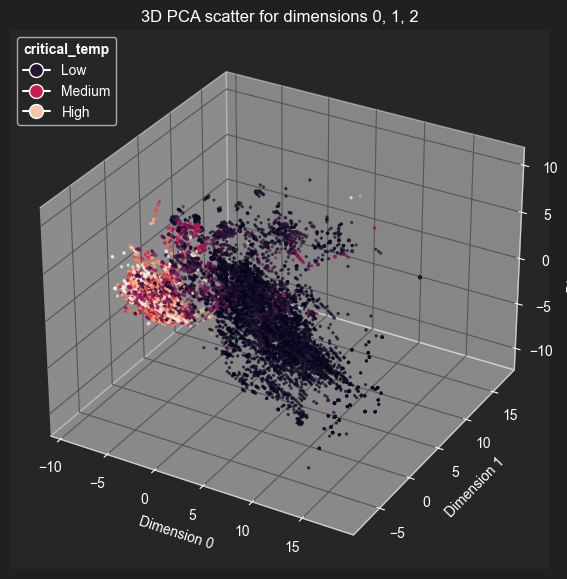

In [7]:
handler.plot_3d_pca(dimensions=[0,1,2], color_by="critical_temp")

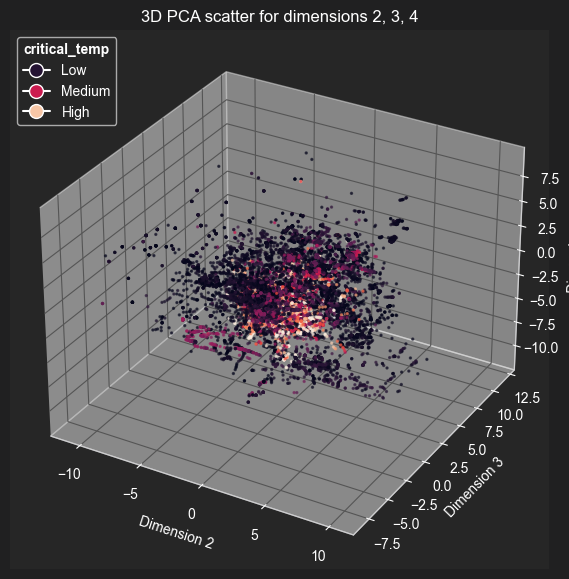

In [10]:
handler.plot_3d_pca(dimensions=[2,3,4], color_by="critical_temp")

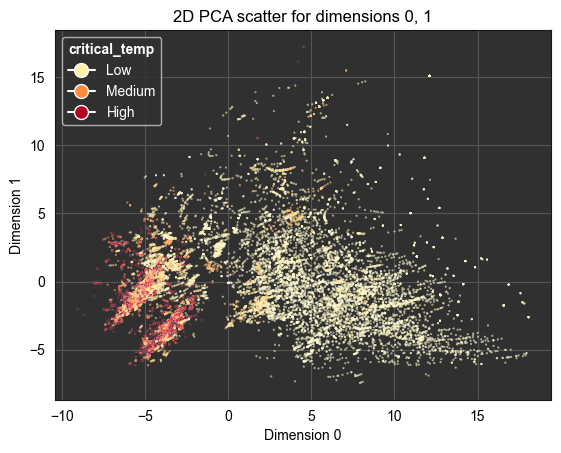

In [17]:
handler.plot_2d_pca(dimensions=[0,1], color_by="critical_temp", cmap="YlOrRd")

Text(0.5, 1.0, 'Critical temperature on first PCA dimension')

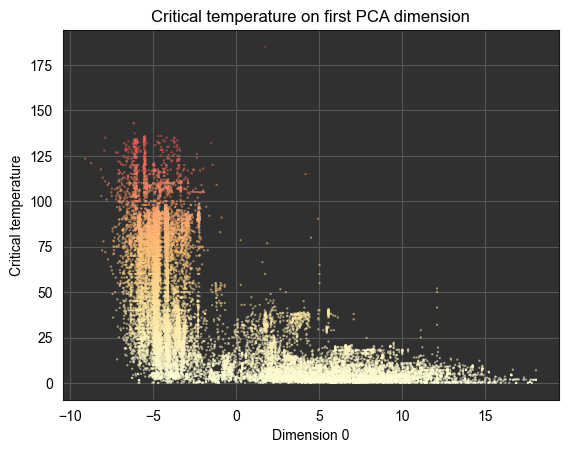

In [24]:
handler.load_theme("light")

sns.scatterplot(
    x=handler.pca_transposed[0], y=handler.y["critical_temp"], s=2, alpha=0.6,
    c=handler.y["critical_temp"], cmap="YlOrRd"
)
plt.xlabel(f'Dimension 0')
plt.ylabel(f'Critical temperature')
plt.title(f'Critical temperature on first PCA dimension', color="black")